In [3]:
starting_links = ['http://115.146.93.142/samplewiki/A12_scale', 'http://115.146.93.142/samplewiki/Gerard_Maley']

# _Task One_

In [336]:
from bs4 import BeautifulSoup
import requests
import re
from robots import process_robots, check_link_ok
from urllib.parse import urljoin

In [355]:

def crawl_seed(seed_url, robot_rules):         # Function to get the url's list
    page = requests.get(seed_url)       # Fetch page
    soup = BeautifulSoup(page.text, 
            'html.parser')              # Seed URL text
    links = soup.findAll('a')           # Find new links to visit 

    # Get links to visit according rules
    to_visit = [urljoin(seed_url, l['href']) 
        for l in links 
        if "href" in l.attrs                              # 1. 'a' elements with href atributes
        if check_link_ok(robot_rules, l['href'])]         # 2. Follow robot rules

    to_visit = list(set([re.sub('#.*', '', i)             # 3. Drop repeated pages
        for i in to_visit 
        if re.match(r'^http://115.146.93.142.*$', i)]))   # 4. Get self domain url's
    return  to_visit

In [356]:
# Task 1 - Get All Links (3 marks)
def task1(starting_links, json_filename):
    # Crawl each url in the starting_link list, and output
    # the links you find to a JSON file, with each starting
    # link as the key and the list of crawled links for the
    # value.
    # Implement Task 1 here

     base_url = 'http://115.146.93.142'                                    # Specify base path for the excercise
     robots_item = '/robots.txt'                                           # Specify the location of robots.txt
     robots_url = base_url + robots_item                                   # Set robots url
     robot_rules = process_robots(requests.get(robots_url).text)           # Get robot rules
     crawled_links = {}                                                    # Set dictionary to gather results to Json format

     # Iterate over starting_links url's
     for seed_link in starting_links:
          visited = []                                                     # Inicialise dictionary to save crawled links 
          link_to_crawl = seed_link                                        # Save link to crawl
          to_visit = crawl_seed(link_to_crawl, robot_rules)                # Get list of links to visit from current seed link

          while(to_visit):                                                 # Iterate while there are remaining links to visit
               next_link = to_visit.pop(0)                                 # Select link and drop from the list of links to visit 

               if next_link not in visited:                                # If the selected link has not been visited, crawl it
                    visited.append(next_link)                              # Append to list of links to visit
                    new_to_visit = crawl_seed(next_link, robot_rules)      # Get list of links to visit from current seed link 

                    # Append links to list of links to visit if the link has not been visited and is not in the links to visit list
                    [to_visit.append(new_link) 
                         for new_link in new_to_visit 
                              if ((not new_link in visited) 
                                   and (not new_link in to_visit))]

          crawled_links[link_to_crawl] = sorted(visited)                   # Save links to dictionary with parenth seed link

     # Convert dictionary into JSON and write file
     with open(json_filename +".json", "w") as outfile:
          json.dump(crawled_links, outfile)

In [357]:
task1(starting_links, 'json_filename')

# _Task Two_

In [40]:
from bs4 import BeautifulSoup
import requests
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from unicodedata import normalize
import json
from robots import process_robots, check_link_ok

# nltk.download('punkt')
# nltk.download('stopwords')

In [282]:
# Task 2 - Extracting Words from a Page (4 Marks)
def task2(link_to_extract, json_filename):
    # Download the link_to_extract's page, process it 
    # according to the specified steps and output it to
    # a file with the specified name, where the only key
    # is the link_to_extract, and its value is the 
    # list of words produced by the processing.
    # Implement Task 2 here

    # Test robot Rules
    robots_url = 'http://115.146.93.142/robots.txt'                 # Set robots url
    robot_rules = process_robots(requests.get(robots_url).text)     # Get robot rules
    if check_link_ok(robot_rules, link_to_extract):
        try:
            steaming_dict = {}

            page = requests.get(link_to_extract)
            soup = BeautifulSoup(page.content, "html.parser", from_encoding = page.apparent_encoding)


            page_content = soup.find('div', id = 'mw-content-text')         # 1.1 Work in the 'div' element with 'id' = 'mw-content-text'
            [val.decompose() for val in page_content.
                find_all('th', class_ = re.compile('infobox-label'))]       # 1.2 Drop the 'th' elements with 'class' = 'infobox-label'
            [val.decompose() for val in page_content.
                find_all('div', class_ = re.compile('printfooter'))]        # 1.3 Drop the 'div' elements with 'class' = 'printfooter'
            [val.decompose() for val in page_content.
                find_all('div', id = re.compile('toc'))]                    # 1.4 Drop the 'div' elements with 'id' = 'toc'
            [val.decompose() for val in page_content.
                find_all('table', class_ = re.compile('ambox'))]            # 1.5 Drop the 'table' elements with 'class' = 'ambox'
            [val.decompose() for val in page_content.
                find_all('div', class_ = re.compile('asbox'))]              # 1.6 Drop the 'div' elements with 'class' = 'asbox'
            [val.decompose() for val in page_content.
                find_all('span', class_ = re.compile('mw-editsection'))]    # 1.7 Drop the 'span' elements with 'class' = 'mw-editsection'

            text = page_content.getText(separator=u' ')                     # 1.8 Get the page text with space separator

            lowercased = text.lower()                                       # 2.1 casefold: Change text to lower case
            normalized = normalize('NFKD', lowercased)                      # 2.1 Normalization: Normalize text applying NFKD
            no_punct = re.sub(r'([^A-z\s])', ' ', normalized)               # 2.2 Punctuation stripoff: Drop non alphabetical/space characters
            no_punct = re.sub(r'[\s]+', ' ', no_punct)                      # 2.3 Spacing characters: Drop repeated spaces and ensure to have only whitespace
            tokens = no_punct.split()                                       # 2.4 Tokenization: Transform text to list of word 
            stop_words = set(stopwords.words('english'))                    # Read English stopwords
            no_stopwords = [w for w in tokens 
                            if not w in stop_words]                         # 2.5 Stopwords: Apply stopwords remover 
            no_stopwords = [w for w in tokens 
                            if not w in stop_words if len(w) >1]            # 2.6 Short tokens: Remove words with less than 2 characters
            porterStemmer = PorterStemmer()                                 # Instantiating the stemmer algorithm
            stemmed = [porterStemmer.stem(w) 
                    for w in no_stopwords]                               # 2.7 Stemming: Stem the words to get common roots
            
            steaming_dict[link_to_extract] = stemmed
        except:
            steaming_dict[link_to_extract] = []
    else:   
        steaming_dict[link_to_extract] = ['a']

    # Convert dictionary into JSON and write file
    with open(json_filename +".json", "w") as outfile:
        json.dump(steaming_dict, outfile)

In [359]:
task2(starting_links[0], 'json_filename_2')

# _Task Three_

In [1]:
import json
import pandas as pd
import task2

In [3]:
# Task 3 - Producing a Bag Of Words for All Pages (2 Marks)
def task3(link_dictionary, csv_filename):
    # link_dictionary is the output of Task 1, it is a dictionary
    # where each key is the starting link which was used as the 
    # seed URL, the list of strings in each value are the links 
    # crawled by the system. The output should be a csv which
    # has the link_url, the words produced by the processing and
    # the seed_url it was crawled from, this should be output to
    # the file with the name csv_filename, and should have no extra
    # numeric index.
    # Implement Task 3 here

    # Empty dataframe to demonstrate output data format.
    dataframe = pd.DataFrame(columns=['link_url', 'words', 'seed_url'])

    for seed in link_dictionary.keys():     # Iterate over seed urls
        for url in link_dictionary[seed]:   # Iterate over link urls

            task2.task2(url, 'json_filename_2')             # Write to Json the List of words

            with open('json_filename_2.json', 'r') as rf:
                word_list = [' '.join(val)                  # Get the list og words from json
                    for val in json.load(rf).values()][0]
                
            to_append = {           # Save values to a dict
                'link_url': [url],
                'words': [word_list], 
                'seed_url' : [seed]}
            
            dataframe = pd.concat(  # Apend dict to dataframe
                [pd.DataFrame(to_append),
                 dataframe.loc[:]]).reset_index(drop=True)
    
    
    dataframe = (dataframe.         # Order values ascending
                 sort_values(['link_url','seed_url']).
                 reset_index(drop=True))   
    
    dataframe.to_csv(csv_filename, index= False)  # Save DataFrame to csv

In [ ]:
task2

In [7]:
with open('task1_sample.json', 'r') as rf:
    t1_dict = json.load(rf)
    
task3(t1_dict, 'csv_filename')
t3 = pd.read_csv('csv_filename')
t2 = pd.read_csv('task3_sample.csv')

In [12]:
# for val in range(0,t3.shape[0]):
#     print(t3.iloc[val,1]==t2.iloc[val,1], t3.iloc[val,0])

# _Task Four_

In [9]:
import task1, task3, json
import pandas as pd
import matplotlib.pyplot as plt
import re

In [10]:
# Helper function to set subplots on figure 1
def plot_bar(ax, df, col_1, title_):
    ax.bar(data=df, x='Words', height='freq', color = col_1)
    ax.set_title(title_)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Words')
    ax.set_ylabel('frequency')

    for label, rect in enumerate(ax.patches):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, 
            height,
            df['freq'][label], 
            ha="center", 
            va="bottom",
            rotation=0, 
            fontsize=12,
            bbox = dict(facecolor = 'whitesmoke', alpha =.8)
        )
    return ax

# Helper function to plot the comparison image
def comparison_plot(topW_0, topW_1, output_plot_filename, starting_links):
    plt.rcParams['figure.figsize'] = [20,8]
    plt.rc('font', size = 15)

    fig, (ax1, ax2) = plt.subplots(1, 2) 
    fig.suptitle('top 10 most common words in each seed_url') 
    ax1 = plot_bar(ax1, topW_0, 'tab:blue', re.sub('http://115.146.93.142/samplewiki/', '', starting_links[0]))
    ax2 = plot_bar(ax2, topW_1, 'skyblue', re.sub('http://115.146.93.142/samplewiki/', '', starting_links[1]))

    plt.savefig(output_plot_filename, bbox_inches='tight')
    plt.show()

In [11]:
# Task 4 - Plotting the Most Common Words (2 Marks)
def task4(bow, output_plot_filename):
    # The bow dataframe is the output of Task 3, it has 
    # three columns, link_url, words and seed_url. The 
    # output plot should show which words are most common
    # for each seed_url. The visualisation is your choice,
    # but you should make sure it makes sense for what it
    # is meant to be.
    # Implement Task 4 here
    top_words = {}

    starting_links = sorted(bow['seed_url'].unique())

    def get_top_words(starting_link, df):
        words_list = []
        [words_list.extend(list.split()) for list in bow[bow['seed_url']==starting_link]['words']]
        df = pd.Series(words_list).value_counts()[:10].reset_index()
        df.columns = ['Words', 'freq']
        return df

    topW_0 = get_top_words(starting_links[0], bow)
    topW_1 = get_top_words(starting_links[1], bow)

    # Create comparison plot
    comparison_plot(topW_0, topW_1, output_plot_filename, starting_links)

    top_words[starting_links[0]] = list(topW_0['Words'].values)
    top_words[starting_links[1]] = list(topW_1['Words'].values)
    return top_words

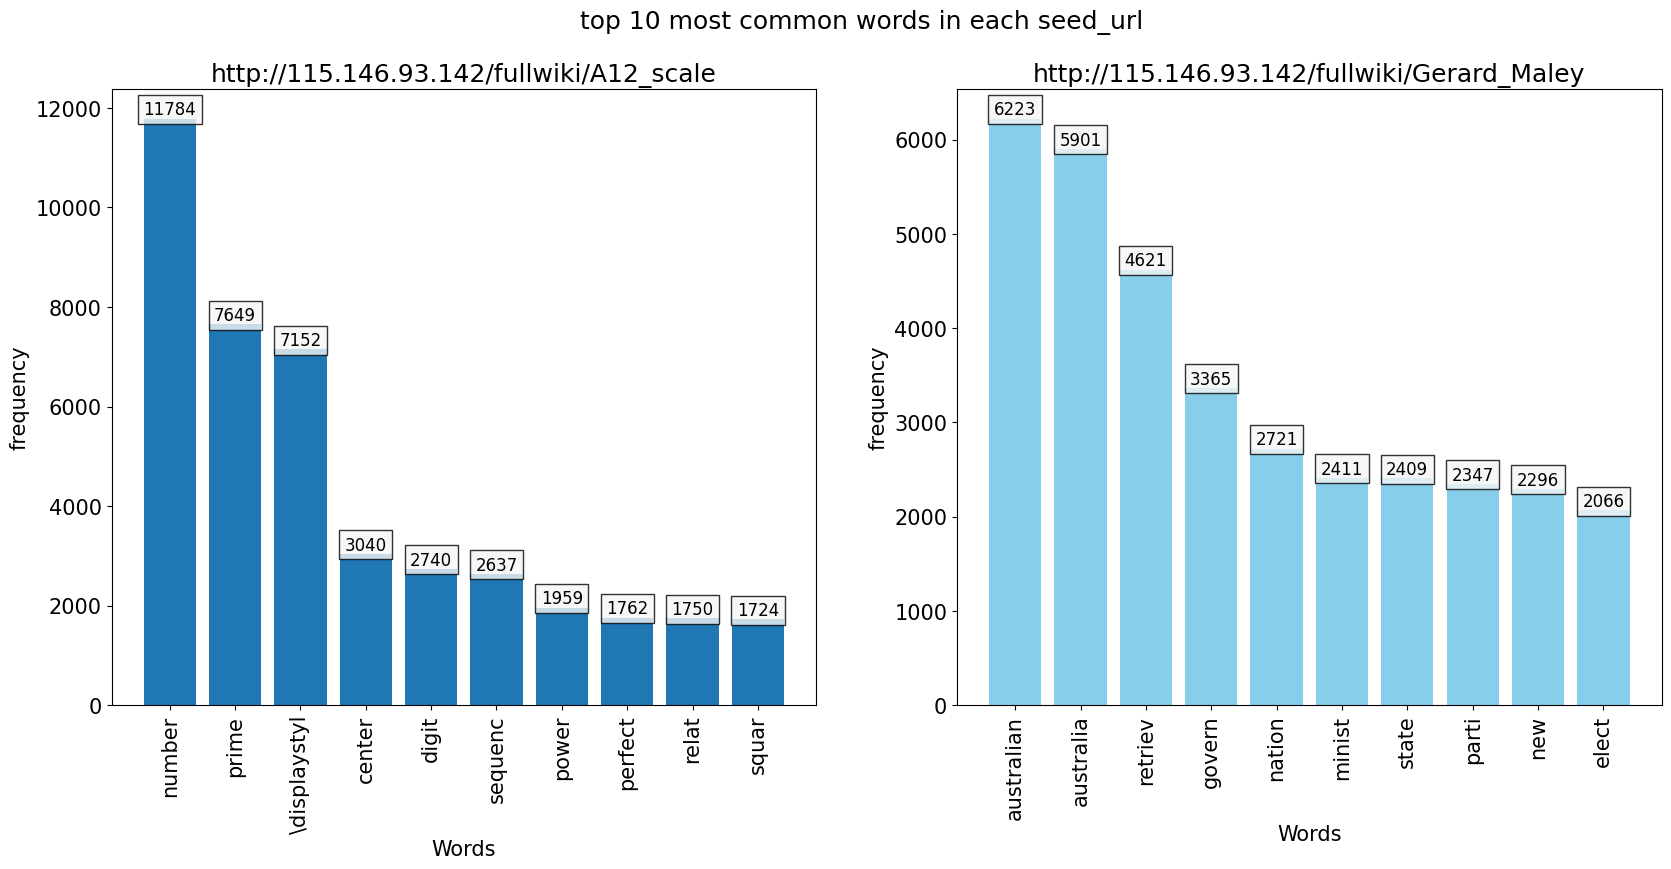

{'http://115.146.93.142/fullwiki/A12_scale': ['number',
  'prime',
  '\\displaystyl',
  'center',
  'digit',
  'sequenc',
  'power',
  'perfect',
  'relat',
  'squar'],
 'http://115.146.93.142/fullwiki/Gerard_Maley': ['australian',
  'australia',
  'retriev',
  'govern',
  'nation',
  'minist',
  'state',
  'parti',
  'new',
  'elect']}

In [13]:
_links = ['http://115.146.93.142/fullwiki/A12_scale', 'http://115.146.93.142/fullwiki/Gerard_Maley']

task1.task1(_links, 'task1')
with open('Output/task1.json', 'r') as rf:
    t1 = json.load(rf)

task3.task3(t1, 'task3')
t3_df = pd.read_csv('Output/task3.csv')

task4(t3_df, 'output_plot_filename.jpeg')

# _Task Five_

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [16]:
# Helper Function to Send pca weights of interest to DF
def get_pca_df(component, pca, vocabulary):
    df = (pd.Series(        
        pca.components_[component], 
        index=vocabulary).sort_values(ascending=False)) 
    df = pd.concat([df[:10], df[-10:]]).reset_index()
    df.columns = ['tokens', 'weights']
    return df

# Helper function to set subplots on figure 1
def plot_bar(ax, df, col_1, col_2, title_):
    ax.bar(data=df[df['weights'] > 0], x='tokens', height='weights', color = col_1)
    ax.bar(data=df[df['weights'] <= 0], x='tokens', height='weights', color = col_2)
    ax.set_title(title_)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xlabel('Words')
    ax.set_ylabel('Weights')

    for label, rect in enumerate(ax.patches):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, 
            height - 0.035 if height > 0 else height + 0.013,
            round(df['weights'][label],2), 
            ha="center", 
            va="bottom",
            rotation=90, 
            fontsize=8,
            bbox = dict(facecolor = 'whitesmoke', alpha =.8)
        )
    return ax

# Helper function to plot the first image
def plot_1(bar_1, bar_2, tokens_plot_filename):
    plt.rcParams['figure.figsize'] = [20,8]
    plt.rc('font', size = 15)
    
    fig, (ax1, ax2) = plt.subplots(1, 2) 
    fig.suptitle('top 10 most positively and negatively weighted tokens and their weights') 

    ax1 = plot_bar(ax1, bar_1, 'tab:blue', 'tomato', 'PCA: Component 0')
    ax2 = plot_bar(ax2, bar_2, 'skyblue', 'indianred', 'PCA: Component 1')
    plt.savefig(tokens_plot_filename+'.png', bbox_inches='tight')
    plt.show()

# Helper function to plot the second image
def plot_2(distribution_plot_filename, X_pca, df):
    plt.rcParams['figure.figsize'] = [8,4]
    plt.rc('font', size = 10)

    sns.scatterplot(x=X_pca[:,0], 
                    y=X_pca[:,1],
                    hue=df['seed_url'].apply(lambda x: re.sub('http://115.146.93.142/samplewiki/', '', x)))
    plt.title("PCA with 2 components")
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    plt.savefig(distribution_plot_filename+'.png', bbox_inches='tight')
    plt.show()


In [17]:
# Task 5 - Dimensionality Reduction (3 marks)
def task5(bow_df, tokens_plot_filename, distribution_plot_filename):
    # bow_df is the output of Task 3, for this task you 
    # should generate a bag of words, normalisation of the 
    # data perform PCA decomposition to 2 components, and 
    # then plot all URLs in a way which helps you answer
    # the discussion questions. If you would like to verify 
    # your PCA results against the sample data, you can return
    # the PCA weights - containing the list of most positive
    # weighted words, most negatively weighted words and the 
    # weights in the PCA decomposition for each respective word.
    # Implement Task 5 here

    vectorizer = CountVectorizer()                          # Call the vectorizer method BOW
    bow = vectorizer.fit_transform(bow_df['words'])         # Apply the BOW over the text corpus
    vocabulary = vectorizer.get_feature_names_out()         # Get the corpus names to re-identify them
    df = pd.DataFrame(bow.toarray(), columns=vocabulary)    # Send the Bow sparce patrix to a DF for further treatment
    norm = Normalizer(norm='max')                           # Call the normalizer method
    normalized_data = norm.fit_transform(df)                # Normalize the data by apllying Normalizer
    pca = PCA(n_components=2, random_state = 535)           # Call PCA instance
    result = pca.fit_transform(normalized_data)             # Transform data with pca

    dict_pca = {}
    for val, component in enumerate(pca.components_):       # Function to set dictonary to return

        # Create DF with PCA results
        df = (pd.Series(component, index=vocabulary).       
                sort_values(ascending=False)) 

        # Create DF with top 10 highest and lowest weighted values 
        df = pd.concat([
            df[:10].reset_index(),
            df[-10:].reset_index()],
            axis=1)
        
        # Set colums names
        df.columns = [ 
            'positive', 
            'positive_weights',
            'negative',
            'negative_weights']
        
        # Fill dictionary to return json
        dict_pca[str(val)] = df.iloc[:,[0,2,1,3]].to_dict('list')

    # Save weights of interes of the PCA components to a DF
    bar_1 = get_pca_df(0, pca, vocabulary)  # Component 0
    bar_2 = get_pca_df(1, pca, vocabulary)  # Component 1

    # Plot figure 2
    plot_2(distribution_plot_filename, result, bow_df)

    # Plot figure 1
    plot_1(bar_1, bar_2, tokens_plot_filename)

    return dict_pca


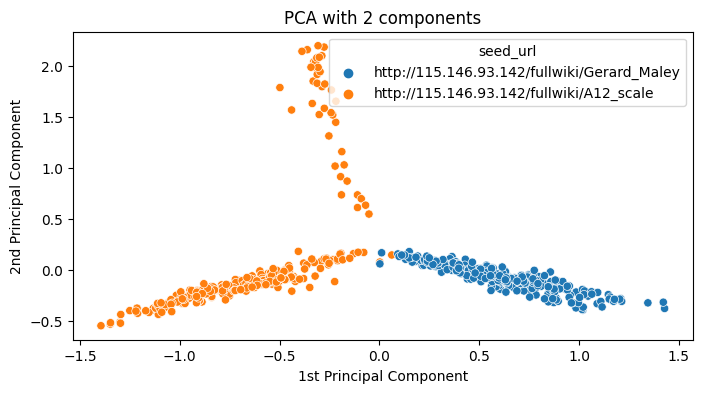

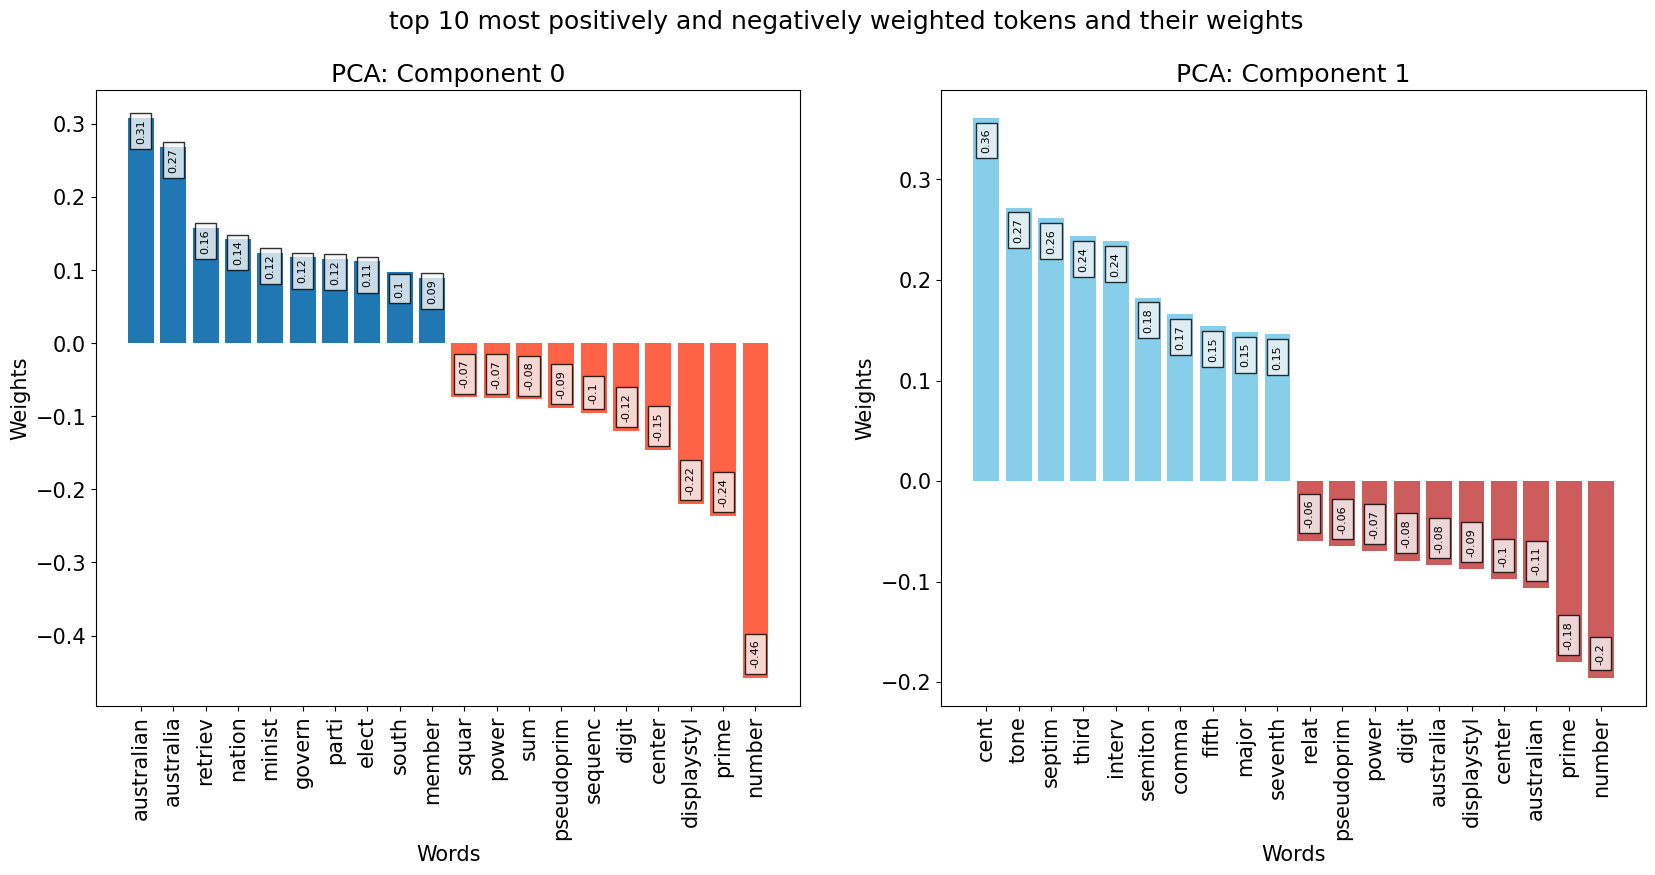

In [18]:
df = task5(t3_df, 'tokens_plot_filename', 'distribution_plot_filename')